In [85]:
# -*- coding: utf-8 -*-
"""
Created on Sat Sep  5 20:34:45 2020

@author: rijub
"""

import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import ConvexHull
import scipy.ndimage.filters as filters




model_name='run9_8'
prediction_arr_dir=os.path.join('Prediction_Plots',model_name +" STM tests arrays")
DataDirectory = 'Data'
loadname = 'MoC2_886_fullimage'
predictions=np.load(os.path.join(prediction_arr_dir,loadname+str(".npy")))


In [86]:
'''
*************************************************
Splits saved predictions up into points for the 2 labeled centerpoint model
*************************************************
'''

size=25
step=1

def split_label_uc(labels,image_size):
    center_atom=np.array([labels[0],labels[1]])*image_size
    return center_atom 


def get_split_labels_arr_uc(arr,image_size=32):
    center_atoms=np.empty((arr.shape[0],arr.shape[1],2))
    for x in range(arr.shape[1]):
        for y in range(arr.shape[0]):
            center_atom_temp=split_label_uc(arr[x,y],image_size)
            center_atom_temp *= size/image_size
            center_atom_temp[0] += step*x
            center_atom_temp[1] += step*y
            center_atoms[x,y]=center_atom_temp
    return center_atoms


center_atoms= get_split_labels_arr_uc(predictions,image_size=32)
flat_center_atoms=center_atoms.reshape(-1,center_atoms.shape[-1])


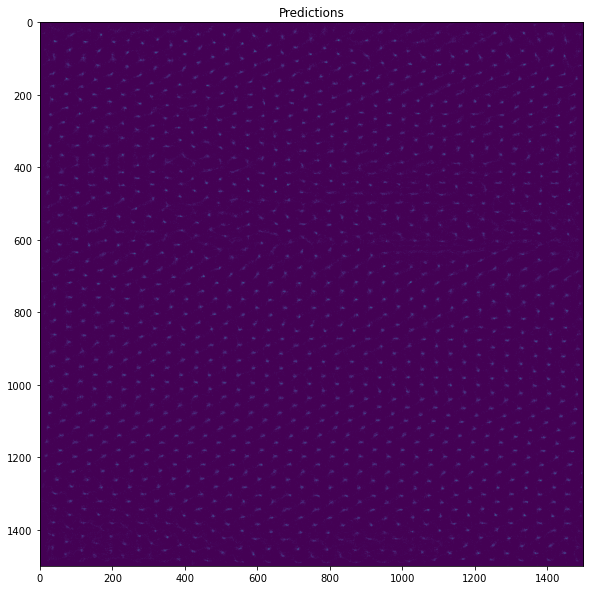

In [88]:
'''
*************************************************
Cell for grouping datapoints.
*************************************************
'''

    
#histogram methods. Either returns the histogram array or plots the histogram
def make_hist_arr(arr,bins):
    x=np.take(arr,0,axis=1)
    y=np.take(arr,1,axis=1)
    H, xedges, yedges= np.histogram2d(x,y,bins=bins)
    return H

data = make_hist_arr(flat_center_atoms,1500) #Larger bins is better.
data=np.transpose(data)

fig=plt.figure(figsize= (10,10))
plt.imshow(data,cmap='viridis', origin = 'upper')
plt.title('Predictions')
plt.show()


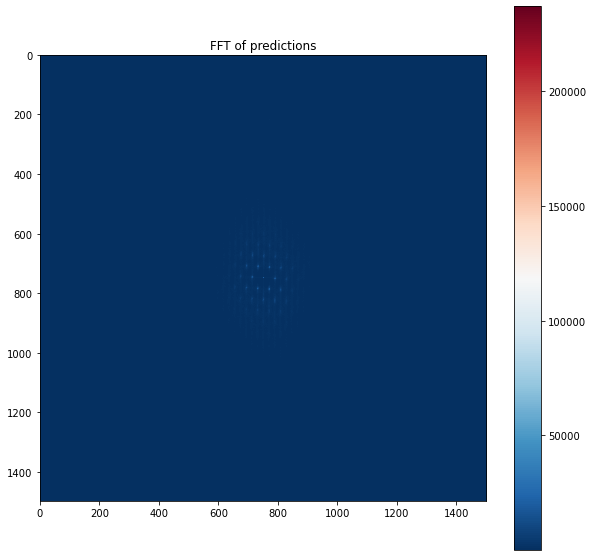

D:\anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log


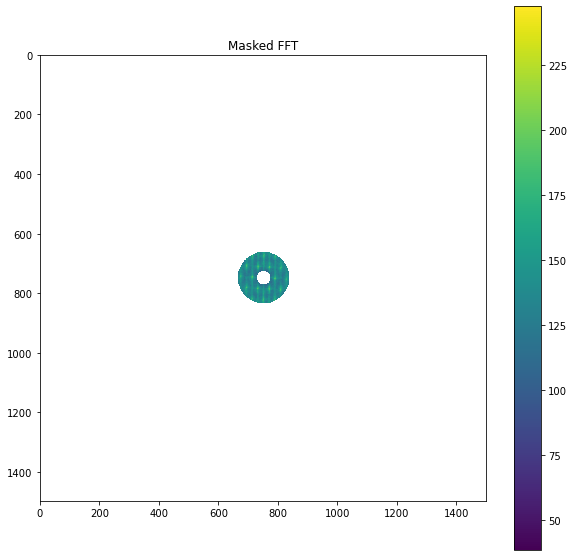

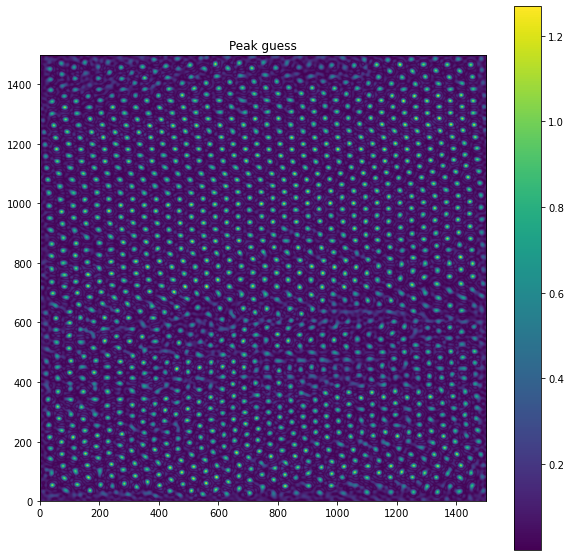

In [91]:
'''
*************************************************
Take FFT, mask and narrow down the regions where the peaks should be
*************************************************
'''
f = np.fft.fft2(data)
fshift = np.fft.fftshift(f)

magnitude_spectrum = np.abs(fshift)
fig=plt.figure(figsize= (10,10))
plt.imshow(magnitude_spectrum, cmap = plt.cm.RdBu_r)
plt.colorbar()
plt.title('FFT of predictions')
plt.show()


def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask
def create_donut_mask(h, w, center=None, inner_radius=None, outer_radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if outer_radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])
    if inner_radius is None:
        inner_radius=0

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask1 = dist_from_center >= outer_radius 
    mask2= dist_from_center <= inner_radius
    mask = mask1 | mask2
    return mask

##Masks for the donut cutout of the lattice
mask1=create_circular_mask(fshift.shape[1],fshift.shape[0],radius=90)
mask2=create_donut_mask(fshift.shape[1],fshift.shape[0],outer_radius=19,inner_radius=1)
fshift[~mask1]=0
fshift[~mask2]=0

maskedSpectrum = 20*np.log(np.abs(fshift))
fig=plt.figure(figsize= (10,10))
plt.imshow(maskedSpectrum, cmap = 'viridis')
plt.title('Masked FFT')
plt.colorbar()
plt.show()

f_ishift = np.fft.ifftshift(fshift)
peakGuess = np.abs(np.fft.ifft2(f_ishift))

fig=plt.figure(figsize= (10,10))
plt.imshow(peakGuess, origin = 'lower')
plt.title('Peak guess')
plt.colorbar()
plt.show()


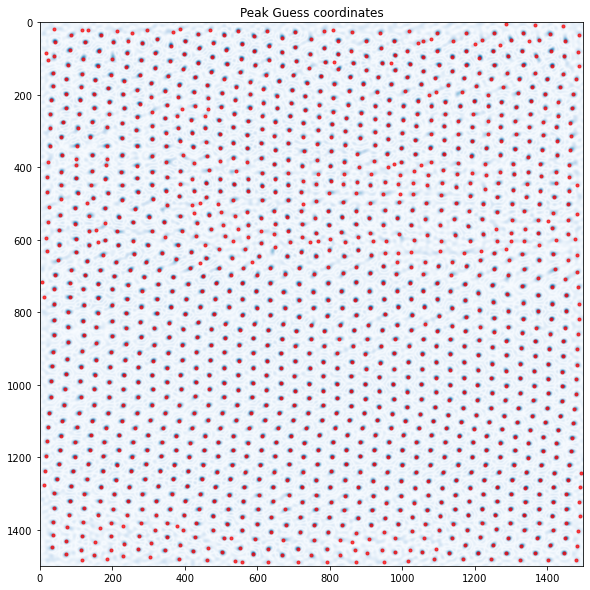

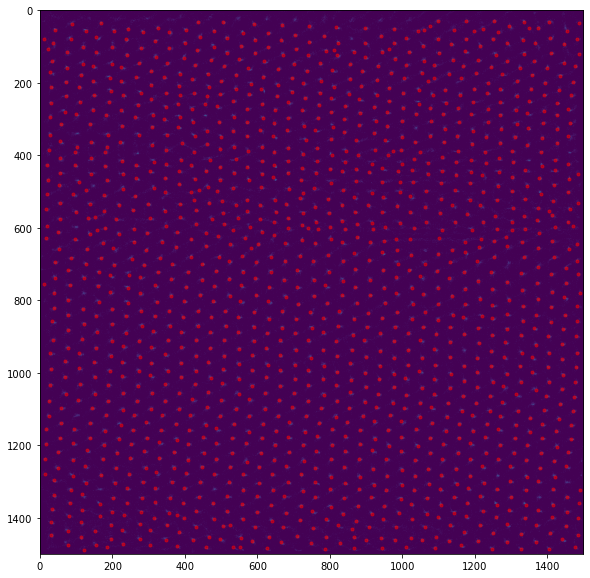

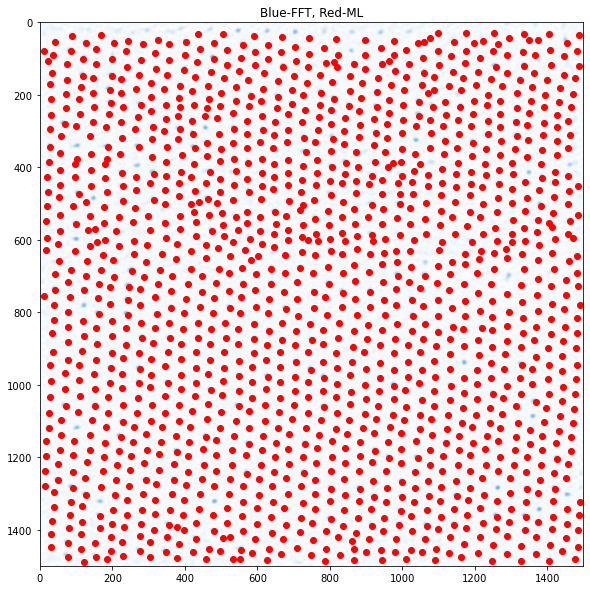

In [106]:
'''
*************************************************
Find peaks in the filtered data and search in its neighborhood to find the 
actual peak in the predictions dataset
*************************************************
'''

neighborhood_size = 20
threshold = 0.2*np.max(peakGuess)

peakGuess_max = filters.maximum_filter(peakGuess, neighborhood_size)
maxima = (peakGuess == peakGuess_max)
peakGuess_min = filters.minimum_filter(peakGuess, neighborhood_size)
diff = ((peakGuess_max - peakGuess_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
x, y = [], []
for dy,dx in slices:
    x_center = (dx.start + dx.stop - 1)/2
    x.append(x_center)
    y_center = (dy.start + dy.stop - 1)/2    
    y.append(y_center)

fig=plt.figure(figsize= (10,10))
plt.imshow(peakGuess, cmap = 'Blues', alpha = 1, origin = 'upper')
plt.scatter(x, y, alpha = 0.7, marker='.', color='r')
plt.title('Peak Guess coordinates')
plt.show()



maxSize = data.shape[0]

Voronoi_x, Voronoi_y = [],[]

for i in range (20, len(x)):
    x_guess = int(x[i])
    y_guess = int(y[i])
    neighborhood = 7
    
    if neighborhood<x_guess<maxSize-neighborhood:
        if neighborhood<y_guess<maxSize-neighborhood:
            slice_of_data = data[x_guess-neighborhood:x_guess+neighborhood, y_guess-neighborhood:y_guess+neighborhood]
            
            PeakValue = np.amax(slice_of_data)
            X1 = 0
            Y1 = 0
            weights = 0

            for j1 in range(0, slice_of_data.shape[0]):
                for j2 in range(0, slice_of_data.shape[0]):
                    weight1 = slice_of_data[j1,j2]
                    if weight1>0.3*PeakValue:    
                        weights = weights+weight1
                        X1 = X1+weight1*j2
                        Y1 = Y1+weight1*j1
            
            if (weights>0 and X1>0 and Y1>0):
                center_x = X1/weights
                center_y = Y1/weights
                Vx = center_x-neighborhood+x_guess
                Vy = center_x-neighborhood+y_guess

                Voronoi_x.append(Vx)
                Voronoi_y.append(Vy)

                
fig=plt.figure(figsize= (10,10))
plt.imshow(data, origin = 'upper')
plt.scatter(Voronoi_x,Voronoi_y,marker = '.', color = 'r', alpha = 0.5)
plt.show()

fig = plt.figure(figsize = (10, 10))
ax = plt.subplot(1,1,1)
ax.imshow(peakGuess, cmap = 'Blues', alpha = 0.5, origin = 'upper')
ax.scatter(Voronoi_x,Voronoi_y, marker = 'o', color = 'r')
plt.title('Blue-FFT, Red-ML')
plt.show()

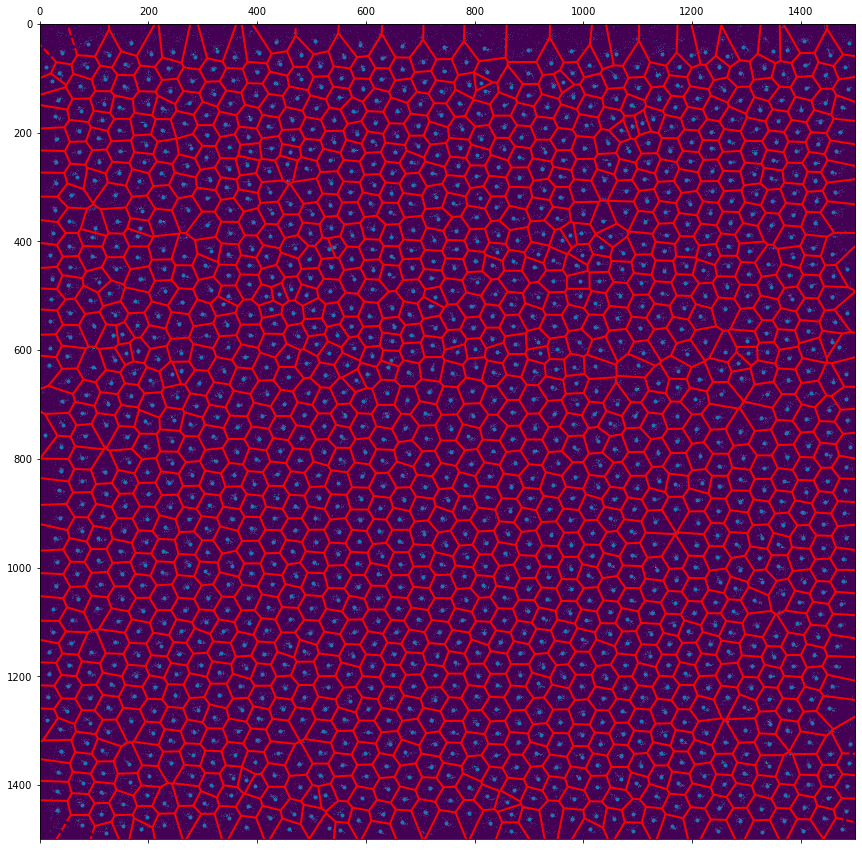

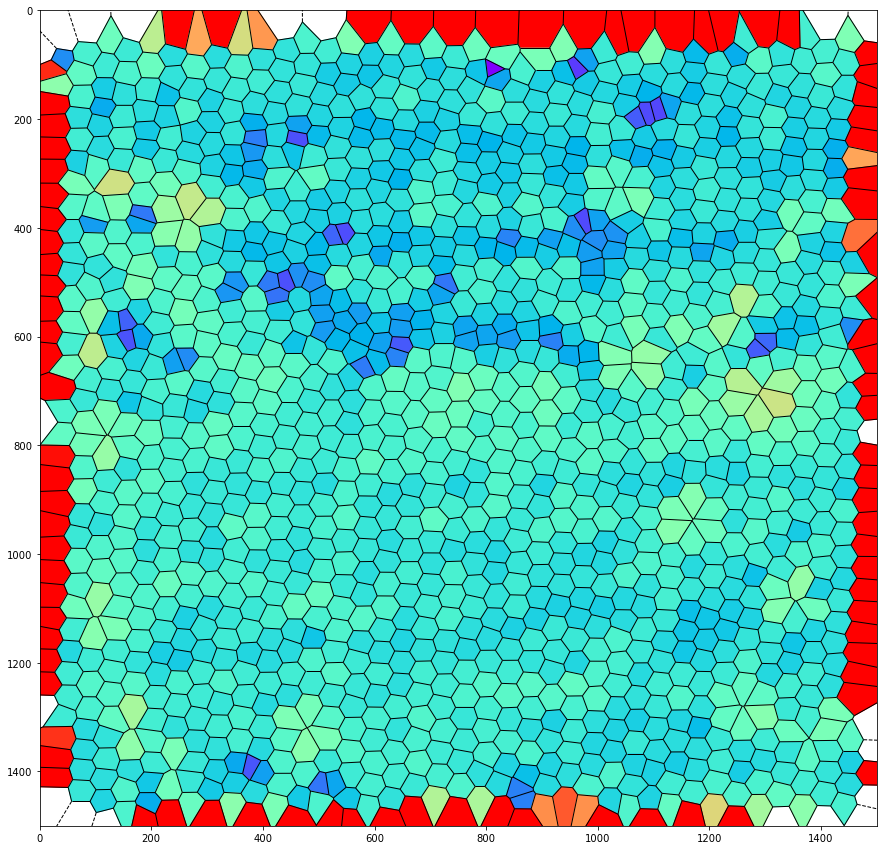

In [105]:
'''
*************************************************
Cell for making Voronoi diagram. Finds all the local maxima
in the image, different from above detect_local_maxima method. 
These maxima are then used to create a voronoi diagram
*************************************************
'''


points=list(zip(Voronoi_x,Voronoi_y))
points=np.array(points)

vor = Voronoi(points)

fig = plt.figure(figsize = (15, 15))
ax = plt.subplot(1,1,1)
ax.matshow(data,cmap='viridis',alpha=1)
voronoi_plot_2d(vor,ax=ax,show_points=True,show_vertices=False,line_width=2,line_colors='red')
plt.ylim(1500,0)
plt.xlim(0,1500)
#plt.savefig(os.path.join(prediction_arr_dir,"MoC2_886_fullimage_Vor_on_histogram"))
plt.show()


atom_locations = vor.vertices

def voronoi_volumes(points):
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    for i, reg_num in enumerate(v.point_region):
        indices = v.regions[reg_num]
        if -1 in indices: # some regions can be opened
            vol[i] = np.inf
        else:
            vol[i] = ConvexHull(v.vertices[indices]).volume
    return vol

Volumes = voronoi_volumes(points)

import matplotlib as mpl
import matplotlib.cm as cm

minima = min(Volumes)
maxima = 0.0002*(Volumes[np.isfinite(Volumes)].max())

norm = mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap='rainbow')

fig = plt.figure(figsize = (15, 15))
ax = plt.subplot(1,1,1)
#ax.matshow(data,cmap='viridis',alpha=1)
voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False, s=1)
for r in range(len(vor.point_region)):
    region = vor.regions[vor.point_region[r]]
    if not -1 in region:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon), color=mapper.to_rgba(Volumes[r]),alpha=1)

plt.ylim(1500,0)
plt.xlim(0,1500)
#plt.savefig(os.path.join(prediction_arr_dir,"MoC2_886_fullimage_Vor_heatmap"))
plt.show()